In [2]:
import sys
if "/Users/raymond/code/FinalProject563" not in sys.path:
    sys.path.append("/Users/raymond/code/FinalProject563")

import time
import torch
import random
import numpy as np
import pandas
import glob
import matplotlib.pyplot as plt
import pickle

import connect_four
import mcts
import connect_net
import connect_plot

In [3]:
files = glob.glob("/Users/raymond/code/FinalProject563/data/trialpretrain01/iteration3/examples-3-*.pickle")
files

['/Users/raymond/code/FinalProject563/data/trialpretrain01/iteration3/examples-3-0-256-256-4.pickle',
 '/Users/raymond/code/FinalProject563/data/trialpretrain01/iteration3/examples-3-2-256-256-9.pickle',
 '/Users/raymond/code/FinalProject563/data/trialpretrain01/iteration3/examples-3-3-256-256-11.pickle',
 '/Users/raymond/code/FinalProject563/data/trialpretrain01/iteration3/examples-3-0-256-256-8.pickle',
 '/Users/raymond/code/FinalProject563/data/trialpretrain01/iteration3/examples-3-2-256-256-5.pickle',
 '/Users/raymond/code/FinalProject563/data/trialpretrain01/iteration3/examples-3-4-256-256-6.pickle',
 '/Users/raymond/code/FinalProject563/data/trialpretrain01/iteration3/examples-3-0-256-256-15.pickle',
 '/Users/raymond/code/FinalProject563/data/trialpretrain01/iteration3/examples-3-3-256-256-3.pickle',
 '/Users/raymond/code/FinalProject563/data/trialpretrain01/iteration3/examples-3-1-256-256-2.pickle',
 '/Users/raymond/code/FinalProject563/data/trialpretrain01/iteration3/examples-3

In [4]:
nnet = connect_net.load_model("/Users/raymond/code/FinalProject563/data/trialpretrain01/iteration3/model-3.model")

ConnectNet(
  (layer1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
  )
  (fc): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 4), stride=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=8, bias=True)
  )
)


In [5]:
examples = []
for f in files:
    with open(files[0], "rb") as f:
        examples += pickle.load(f)
examples = list(reversed(examples))

In [6]:
for item in examples:
    output = connect_four.to_rep(item[0])
    start_state = output == "111111111111111111111111111111111111111111"
    item.append(start_state)

In [7]:
new_examples = []
new_list = None
for item in examples:
    if item[4]:
        if new_list is not None:
            new_examples.append(new_list)
        new_list = []
    new_list.append(item)
else:
    new_examples.append(new_list)

In [8]:
total_num = len(new_examples)
train_num = int(total_num * 0.85)
val_num = total_num - train_num
# test_num = total_num - train_num - val_num
print(total_num, train_num, val_num)

shuffled_indexes = list(range(total_num))
random.shuffle(shuffled_indexes)

train_games = [new_examples[i] for i in shuffled_indexes[:train_num]]
val_games = [new_examples[i] for i in shuffled_indexes[train_num:]]
# test_games = [new_examples[i] for i in shuffled_indexes[train_num+val_num:]]

1536 1305 231


In [9]:
train_boards = torch.stack([m[0] for g in train_games for m in g])
train_scores = torch.Tensor([m[3] for g in train_games for m in g])
train_moves = torch.stack([m[1] for g in train_games for m in g])
print(train_boards.shape, train_scores.shape, train_moves.shape)

val_boards = torch.stack([m[0] for g in val_games for m in g])
val_scores = torch.Tensor([m[3] for g in val_games for m in g])
val_moves = torch.stack([m[1] for g in val_games for m in g])
print(val_boards.shape, val_scores.shape, val_moves.shape)

# test_boards = torch.stack([m[0] for g in test_games for m in g])
# test_scores = torch.Tensor([m[3] for g in test_games for m in g])
# test_moves = torch.stack([m[1] for g in test_games for m in g])
# print(test_boards.shape, test_scores.shape, test_moves.shape)

torch.Size([36958, 6, 7]) torch.Size([36958]) torch.Size([36958, 7])
torch.Size([6530, 6, 7]) torch.Size([6530]) torch.Size([6530, 7])


In [10]:
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
losses_train = []
losses_validation = []

In [11]:
def loss_fn(est_scores, est_probs, target_scores, target_probs):
    loss_scores = (est_scores - target_scores).square().sum()
    loss_probs = (target_probs * est_probs.log()).sum()
    loss_total = loss_scores - loss_probs
    return loss_total


In [14]:
for i in range(500):
    start_time = time.time()
    v, proba = nnet(train_boards.view(-1, 1, 6, 7))
    train_loss = loss_fn(v, proba, train_scores, train_moves)
    losses_train.append(train_loss.item())
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    v, proba = nnet(val_boards.view(-1, 1, 6, 7))
    val_loss = loss_fn(v, proba, val_scores, val_moves).item()
    losses_validation.append(val_loss)
    if i % 10 == 0:
        print(f"EPOCH::{i}  LOSS::{val_loss:.4f}  TIME::{time.time() - start_time:.4f}")

EPOCH::0  LOSS::5554.5527  TIME::2.5446
EPOCH::10  LOSS::5511.9131  TIME::2.3860
EPOCH::20  LOSS::5499.2593  TIME::2.4202
EPOCH::30  LOSS::5471.8862  TIME::2.4046
EPOCH::40  LOSS::5442.8872  TIME::2.4009
EPOCH::50  LOSS::5416.4761  TIME::2.3961
EPOCH::60  LOSS::5400.8052  TIME::2.3903
EPOCH::70  LOSS::5412.6074  TIME::2.4011
EPOCH::80  LOSS::5382.8291  TIME::2.4075
EPOCH::90  LOSS::5359.3901  TIME::2.3949
EPOCH::100  LOSS::5375.6074  TIME::2.4179
EPOCH::110  LOSS::5353.0776  TIME::2.4112
EPOCH::120  LOSS::5333.4526  TIME::2.4124
EPOCH::130  LOSS::5320.1646  TIME::2.4051
EPOCH::140  LOSS::5313.2266  TIME::2.4073
EPOCH::150  LOSS::5292.2271  TIME::2.4010
EPOCH::160  LOSS::5284.0396  TIME::2.4112
EPOCH::170  LOSS::5360.0146  TIME::2.4018
EPOCH::180  LOSS::5285.5620  TIME::2.4281
EPOCH::190  LOSS::5277.0991  TIME::2.4215
EPOCH::200  LOSS::5261.3574  TIME::2.4188
EPOCH::210  LOSS::5265.9683  TIME::2.3953
EPOCH::220  LOSS::5281.5083  TIME::2.4185


KeyboardInterrupt: 

<AxesSubplot:>

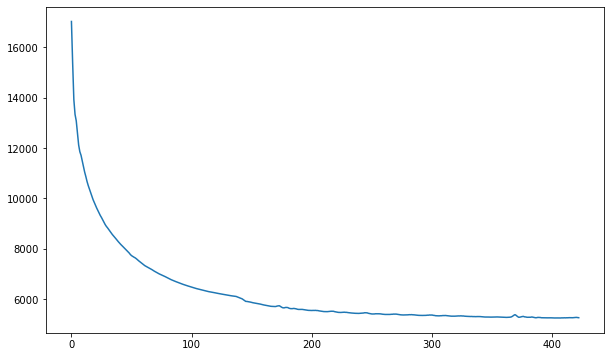

In [15]:
pandas.Series(losses_validation).plot(figsize=(10, 6))

In [16]:
connect_net.save_model(nnet, "../models/pretrain01-iter03.model")